In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from agents import FrustratedRescorlaAgent


# Test agent

## Test performance monitoring

### Generate random sequence of rewards

In [2]:
# random sequence of rewards
rewards = np.random.binomial(1, .6, 10000)

### Compute value function with multiple alpha values

In [3]:
agent = FrustratedRescorlaAgent()  # initialize agent

In [4]:
# run agent and save values
alphas = np.linspace(0, 1, 11)  # learning rates
values = np.empty((len(alphas), len(rewards)))  # save values for each alpha

for a, alpha in enumerate(alphas):
    agent.ALPHA = alpha  # reset agent' learning rate

    # run agent and save values
    for r, reward in enumerate(rewards):
        agent.update_value(reward)  # update value
        values[a, r] = agent.value  # save value

values.shape

(11, 10000)

### Fit regression and plot coefficients

In [5]:
# logistic regression to predict values from rewards
len_history = 10

# dataset is the history of rewards
X = np.empty((len(rewards)-len_history, len_history))
y = np.empty(len(rewards)-len_history)


coeffs_all = np.empty((len(alphas), len_history))

for i, alpha in enumerate(alphas):
    values_temp = values[i, :]

    # create dataset X
    for j in range(len(rewards)-len_history):
        X[j, :] = rewards[j+1:j+len_history+1]
        y[j] = values_temp[j+len_history]

    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True)

    # fit model 
    model = LinearRegression()
    model.fit(X_train, y_train)

    # get coefficients
    coefs = model.coef_
    coeffs_all[i, :] = coefs    

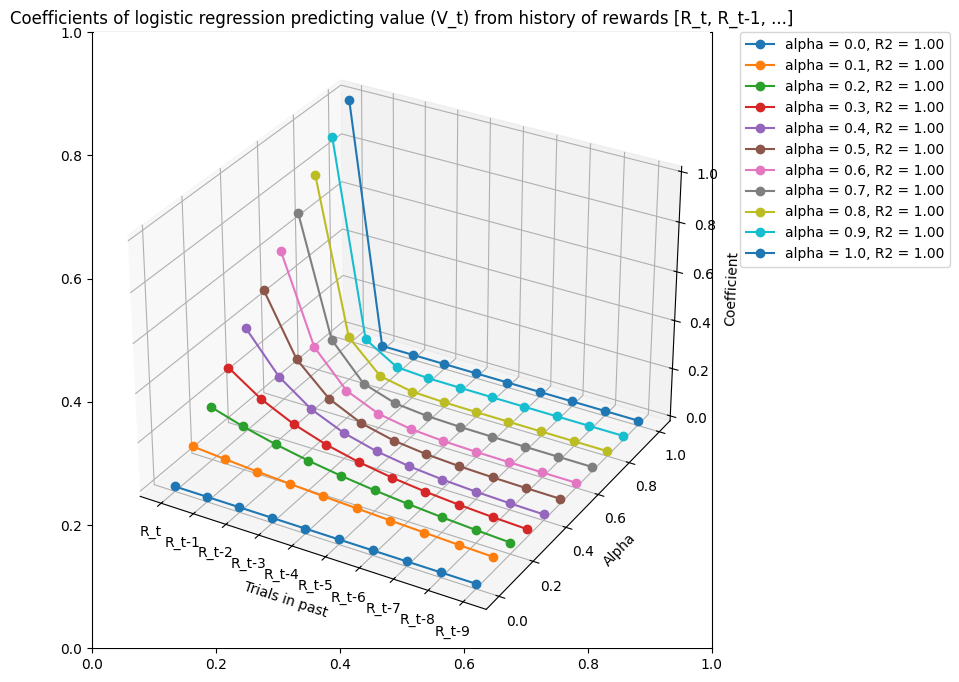

In [6]:
# 3d plot
fig, ax = plt.subplots(figsize=(8, 8))
ax = plt.axes(projection='3d')

for i, alpha in enumerate(alphas):
    coefs = coeffs_all[i, :]
    xdata = np.arange(len(coefs))
    zdata = coefs[::-1]
    ydata = alpha * np.ones(len(coefs))
    ax.plot3D(xdata, ydata, zdata, 'o-', label=f"alpha = {alpha:.1f}, R2 = {model.score(X_test, y_test):.2f}")

ax.set_xlabel("Trials in past")
ax.set_ylabel("Alpha")
ax.set_zlabel("Coefficient")
xlabels = ['R_t', 'R_t-1', 'R_t-2', 'R_t-3', 'R_t-4', 'R_t-5', 'R_t-6', 'R_t-7', 'R_t-8', 'R_t-9']
ax.set_xticks(np.arange(len(xlabels)))
ax.set_xticklabels(xlabels)
ax.set_title("Coefficients of logistic regression predicting value (V_t) from history of rewards [R_t, R_t-1, ...]")
# legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# hide spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

### Compare recovered parameters to analytical solution

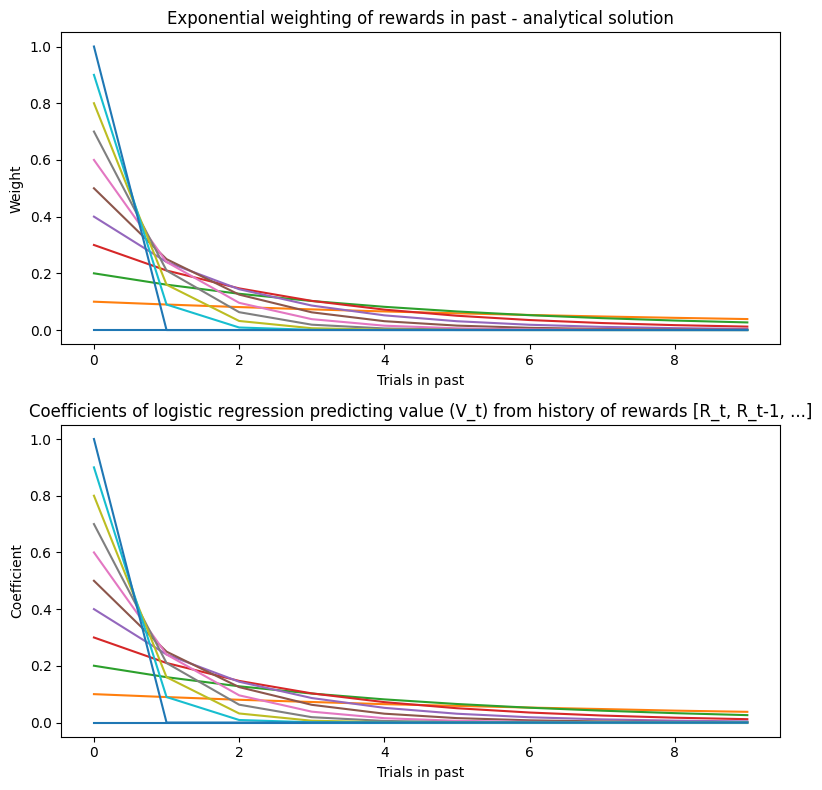

In [7]:
# analytic solution for the exponential weighting

weights = alphas * (1 - alphas) ** np.arange(len_history)[:, None]


fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(np.arange(10), weights)
axs[0].set_xlabel("Trials in past")
axs[0].set_ylabel("Weight")
axs[0].set_title("Exponential weighting of rewards in past - analytical solution")

axs[1].plot(coeffs_all.T[::-1])
axs[1].set_xlabel("Trials in past")
axs[1].set_ylabel("Coefficient")
axs[1].set_title("Coefficients of logistic regression predicting value (V_t) from history of rewards [R_t, R_t-1, ...]")

plt.tight_layout()
plt.show()

## Test explore-exploit state and action selection

### Generate states and actions

In [8]:
# initialize agent
agent = FrustratedRescorlaAgent()
#agent.V_SHIFT = .15
initial_action = 0

In [9]:
# parameters of simulation
n_trials = 1000
values_to_test = np.linspace(0, 1, 101)
# sample 6 values from 0 to 100, log scale
betas = np.logspace(-1, 2, 6)

# test agent: make decision from different values, 1000 times each value
actions = np.empty((len(betas), n_trials, len(values_to_test)))
states = np.empty((len(betas), n_trials, len(values_to_test)))

for b, beta in enumerate(betas):
    for j, init_value in enumerate(values_to_test):
        # set agent parameters
        agent.value = init_value
        agent.BETA = beta

        for i in range(n_trials):
            # update state
            agent.update_state() 

            # get state
            current_state = agent.state
            states[b, i, j] = 1 if current_state == 'exploit' else 0  # save state as binary

            # get action (based on state)
            agent.action = initial_action  # init action with target 0
            current_action = agent.make_choice()  # make choice
            actions[b, i, j] = current_action  # save action



### plot probab switch


In [10]:
# analytical solution
def softmax(beta, V, v0=.35):
    return 1- np.exp(beta * V) / (np.exp(beta * V) + np.exp(beta * v0))

probs = np.zeros((len(betas), len(values_to_test)))
for i, beta in enumerate(betas):
    probs[i, :] = softmax(beta, values_to_test, agent.V_SHIFT)


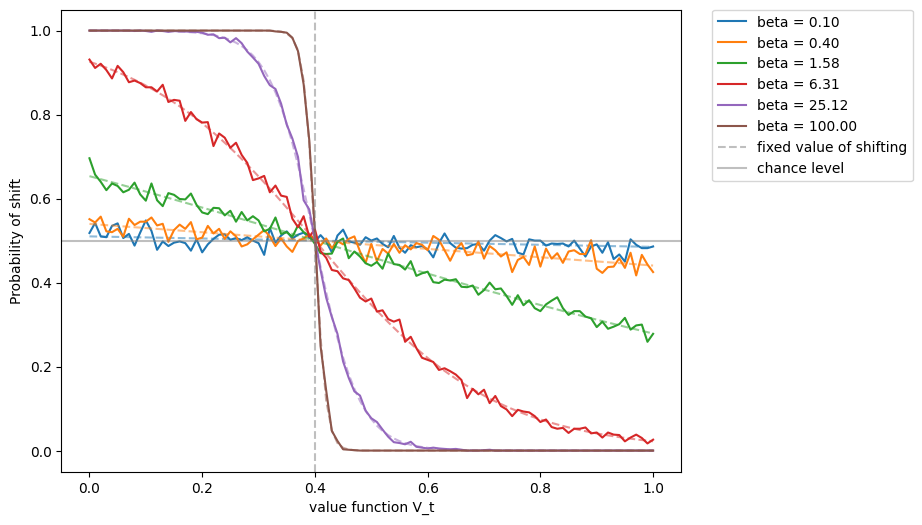

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

for b, beta in enumerate(betas):
    current_states = states[b, :, :]
    ax.plot(values_to_test, 1-current_states.mean(axis=0), color=colors[b], label=f"beta = {beta:.2f}")
    plt.plot(values_to_test, probs[b, :], color=colors[b], linestyle='--', alpha=.5)


# vertical line at V_SHIFT
plt.axvline(x=agent.V_SHIFT, color='grey', linestyle='--', alpha=.5, label="fixed value of shifting")
# horizontal line at .5
plt.axhline(y=.5, color='grey', alpha=.5, label="chance level")
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.xlabel("value function V_t")
plt.ylabel("Probability of shift")

# legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### plot decision

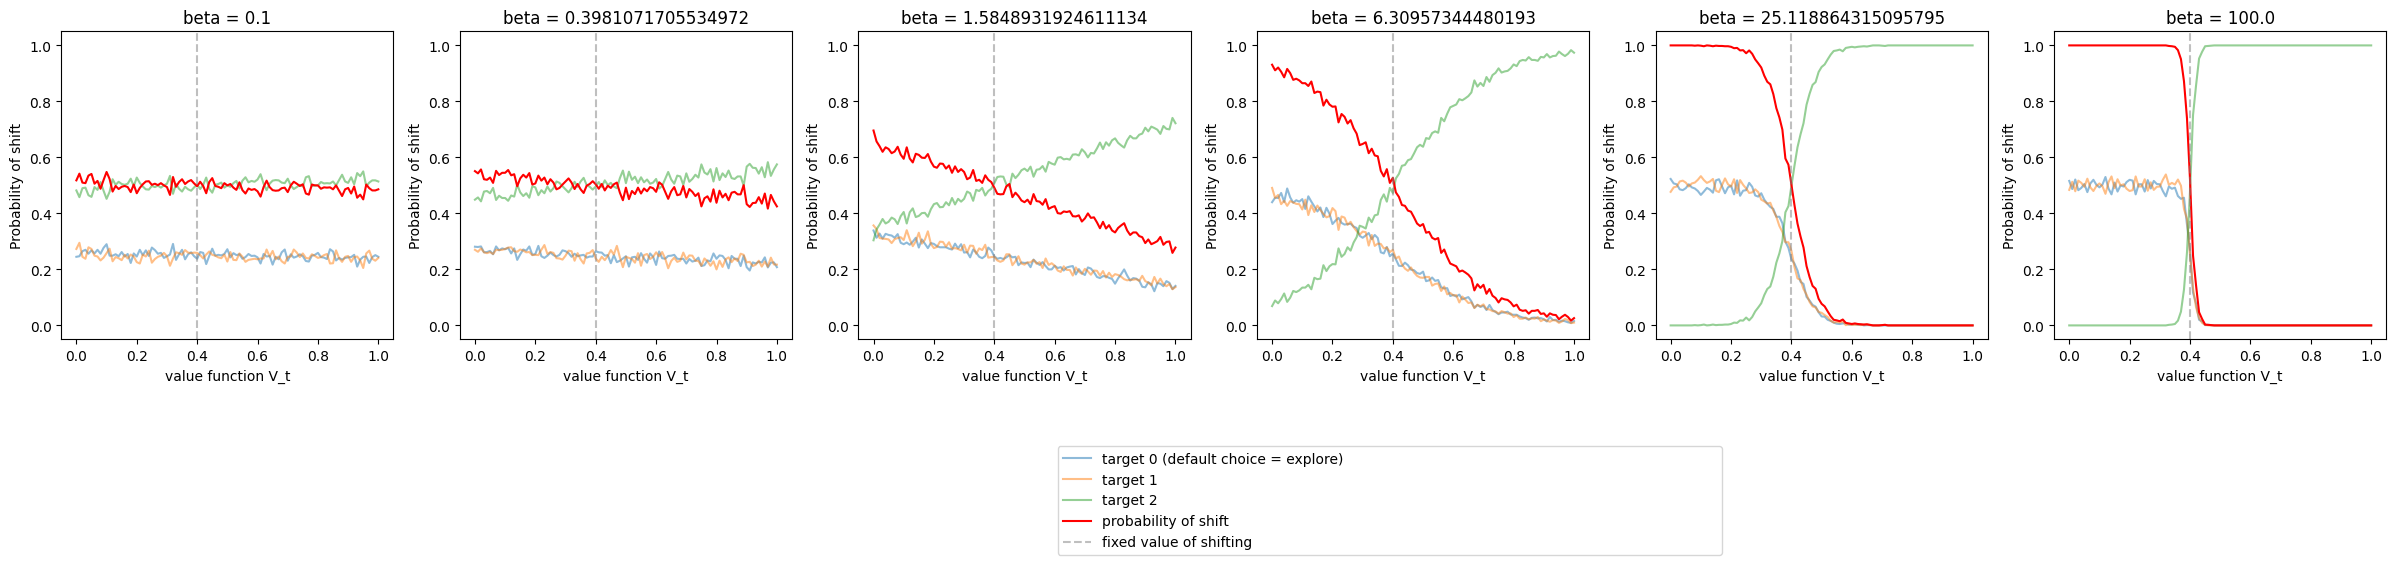

In [12]:
fig, axs = plt.subplots(1, len(betas), figsize=(5*len(betas), 4))

for b, beta in enumerate(betas):
    current_actions = actions[b, :, :]
    axs[b].plot(values_to_test, (current_actions==0).mean(axis=0), alpha=.5, label="target 0 (default choice = explore)")
    axs[b].plot(values_to_test, (current_actions==1).mean(axis=0), alpha=.5, label="target 1")
    axs[b].plot(values_to_test, (current_actions==2).mean(axis=0), alpha=.5, label="target 2")

    # plot probability of shifting
    current_states = states[b, :, :]
    axs[b].plot(values_to_test, 1-current_states.mean(axis=0), color='red', label="probability of shift")

    axs[b].axvline(x=agent.V_SHIFT, color='grey', linestyle='--', alpha=.5, label="fixed value of shifting")

    axs[b].set_title(f"beta = {beta}")
    axs[b].set_ylim(-.05, 1.05)
    axs[b].set_xlim(-.05, 1.05)
    axs[b].set_xlabel("value function V_t")
    axs[b].set_ylabel("Probability of shift")

# legend under plot
plt.legend(bbox_to_anchor=(-3, -.7, 2, .2), loc='lower left',
            ncol=1, mode="expand", borderaxespad=0.)